# Unzipping, splitting and preprocessing of the dataset

In [216]:
import os
import pandas as pd
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from skimage.feature import match_template

In [217]:
# reading the data
os.chdir(os.getcwd() + '/fer2013')
full_data = pd.read_csv('fer2013.csv')
os.chdir('../')
print('Current directory: {} \n'.format(os.getcwd()))
full_data.head()

Current directory: C:\Users\Maksim Komatovskiy\Desktop\cv_proj 



,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [218]:
# here different helper functions are created

def str2array(string):
    img_array = np.array(string.split(' ')).astype(np.int64)
    return img_array

def create_subset_labeled_with(label,full_data):
    subdata = full_data[full_data['emotion'] == label]
    return subdata

def construct_a_batch(list_of_datasets,size_by_ten):
    batch = pd.DataFrame()
    
    for sub in list_of_datasets:
        idx = np.random.randint(0,len(sub),size_by_ten)
        subb = sub.iloc[idx]
        batch = pd.concat([batch,subb])
    return batch

from tqdm import tqdm

def create_F_matrix_from_subdataset(subdataset):
    F0 = subdataset['pixels'].iloc[0].reshape(-1,1)

    for i in tqdm(range(1, len(subdataset))):
        F0 = np.append(F0,subdataset['pixels'].iloc[i].reshape(-1,1),axis = 1)
        
    return F0

def mean_column(A):
    return A.mean(axis = 1)

def subtract_column_mean(A):
    column_mean = mean_column(A)
    return A - column_mean.reshape(-1,1)

def approximate_with_rank(A,r,return_decomposition = False):

    u,s,vh = np.linalg.svd(A,full_matrices = False) # decomposition
    #print(u.shape, s.shape,vh.shape)
    s = s[:r] #truncation
    u = u[:,:r]
    vh = vh[:r,:]
    #print(u.shape, s.shape,vh.shape)
    
    if return_decomposition:
        return u,s,vh
    else:
        A_ = np.dot(u,np.dot(np.diag(s),vh))
        return A_

def plot_eigf(U0,y):
    for i in range(y):
        f = U0[:,i]
        f = f.reshape(48,48)
        plt.figure(figsize = (8,8))
        plt.imshow(f,cmap = 'gray')
        plt.show()
        
def clean(img, t1):
    
    img = img.reshape(48,48)
    corr_skimage = match_template(img, t1, pad_input=True)
    un = (corr_skimage > 0.53)
    if (np.unique(un[12:22,9:18]) != False).any() and (np.unique(un[12:22,30:39]) != False).any() and (img.sum() > 220000) and (img.sum() < 400000):
        return 1
    else: return 0

In [219]:
# turn the data in the dataframes into the usable format

full_data['pixels'] = full_data['pixels'].apply(lambda x: str2array(x))

full_data['emotion'] = full_data['emotion'].apply(lambda x: np.int64(x))

In [220]:
# CLEANING THE DATASET

# needed inputs and templates

img = full_data['pixels'].iloc[33].reshape(48,48)
t1 = img[15:25,8:20]

    
# applying the cleaning function

full_data['deсision'] = full_data['pixels'].apply(lambda x: clean(x, t1))


# keep only the appropriate ones

full_data=full_data.drop(full_data[full_data['deсision']==0].index)

In [221]:
len(full_data)

6259

In [222]:
# Random train-test split

random.seed = 42

test_percentage = 0.2

test_indices = np.random.choice(range(0,len(full_data)),
                                      size = int(test_percentage*len(full_data)),
                                      replace = False,)

test_set = full_data.iloc[test_indices]
full_data.drop(test_indices,axis = 0,inplace = True)


KeyError: '[5843 2698 2068 1673 2108 3530 1651 1123 4502 4852  889 5867  275 2624\n 5752  160 4139 5787 4560 3773 3989 1243 4801 4207 1046 2993 2629 5905\n 2099 1230 1593 5679 6245 3153 6166 1061 3617 5354 1189 5428 1555 4342\n 4486 5188  855 3313  958 1828 6157 1338 4652 3073  302 3970 1175 1851\n  791  681 4272 1172 6127  853  915 5881  307 1330 2358 5211 3796 5442\n 2573  378 1444 4742 2591 3102  159 5217  985 5390 5732 5244  483 1399\n 1648 2064 6250 1473 3461  801 2531 1587 2901 1184 1842 5581 5765 4723\n  986 4680 1745 3910 5288 3705 3090 2397 3133 4334 4062 4041 5768 4010\n 4257  329  460 3949 3131 1769 4532 4971 5855 5307 3657 1055  198 2274\n 3353  463 5904  289 3482 4681 4858 2219 2041 2743 3015 2147 4843 1919\n  804 4304   25  566 3254 1079 3724 5118  851  322 3456 5983 4208 2185\n 4978  395 1434   54  282  637  929  883 4221 1813 5294 5518 3488 3510\n 5528 4816  414 1968 1285 1406 4389 5343 2871  670 1010 2817 1715 5727\n 2815 3428 4038 2546  334 2580  642 3312  452 2414 4515 2456  683 6181\n 6116 2900 3772 1656 6170 4092 1951 2027 3497 4215 5818 5105 2966 3026\n 4748  493 4561 6010 3491 3204 1950 1143 5945  927 2979 3789 5336 5082\n 5216 1028 2327 4176 1190 3267  424 4183 1031 3195 1366  866 6237 2445\n 4377 1579 4521 4156 1734 4091 2961  605 2790 4554 4704 1108 3971 3842\n 5091 3978 5424 1863  363 5094 2898 3031 2314 4752 3819  966 6075 4889\n  921  102 6131 3352 1127  733 5694 6055 3659 5831 3893  771 1476 1557\n 3421 3113 3770 4624 5096 3288 5447 1803 2469  779 5425  760 6066 2013\n 3092 4522 5932 5187 3450 4620 2917 4284  669 2882  813 5663 5339   85\n 4392 1334  789 4465 2204 4726 2381  911  873 4007 1223 5958 4267 2711\n 4127 2089 4836 1790 5076 2946 3735 3111 2484 1698 3059 3722 2261 4296\n 3712 4641 4708 1211 2852 1644 2131 1103 1266 4223 5878 2032  754 2451\n 2550 6249 6257  230 5340 5684 5323 1645 4175 3241 4539 6239  449 3950\n 5548  728 4877 4902 5300 1513 4136 3913 1225 2356 1268 6037 4493  574\n  299 2731 1532 4692 2078 1212 4757 1688 6100 5167 6241 1778  944 1634\n 3725 1078 1929 1270 1069 4719 1450  323 4130 1350 3812 4327 5251 4361\n 1065 1396 2757 2818 3929 1122  283 1597 3420 3707 5297 2583 4427 1283\n 5594 4418 1537 2777 3320 3462  885 2220 5628 5981 1741 2634 2106 4227\n  821 1383 2619 4754 1901 4929 4143 5357 1152 5585 5800 5882  552 3607\n 1541 3696 4101 4616 2387 4633 5667 5469 4565 3394  903 2140 1603 2523\n 5045 4387 3377 1365  980  324 1034 1237 3579 2155 5394 4064 2113 5986\n 3618  274 1116 5232 4685  902 1844  266 5639 5475 2146 4589  318 2637\n 5951 2012 1760  461  532 3957 1788 5108 6069 5258  220 1536 5833 1009\n 5534 1880 1888 3322 1151 3367 1988 4294 6089 5988 1747 5398  895  691\n 3987 5851 2306 1395  519 1975  706 2474   62 3830  847  937  510 6061\n 3156 3872 4785 2379 2422 5551 1317 3821 2606 5712  585 1004 1319 3699\n 3580 6201 5030 6228   17 2507 1647 3004 3856 4683  677 4664  846 2097\n 1369 2486 2388 6210 4140 5571 4663 2599  256 1052 4124 4659 1565 2438\n 5703  772 4882 5869 3194  869 6195 4171 1302 2468 1799 4352 2642 5257\n 1502  182 4179 1808 2780 5625 1111 1382  560 3514 4084 2663 2029 4919\n 1245 5117 5025 3489  345 4913 2398 1095  908 4810 4177 2442 3024 2323\n 3146 4268 3679 1005  815 3747 2452 3061 4870 2603 4734 3645 4898 4571\n 3143 5529 5050 5897 1876 2292 5919 5543 1058 1961  432  828 5269 3240\n 6105 2578 1998 1011 2176 4693 5758 2980 5264 1967  105 3798 1313 2141\n 1293 6227 1262 2373  817 5763 3873 2479 3799 5206  767 6233  129 6029\n 1802 3904 2434 5860 6094  797 4448  249   48 4364 2143 4421 4731 5271\n 2612 5226 4654 5034 5978 4042 4144 4305  499 2487 2722 4128  654 3606\n 3513 3411 1048 3784 4485 2661 3458  438 2938 3523 4089 3120  258 4385\n 4861  592 4079 2997 6134 2102 5178 3675 1469 6027 1357 2142 3325  453\n 1305   80 3825 1915 2994 2162 2392 5600 4117 4490  659 5889 1117 1484\n 1220 3652  983 4149   22 5431 5077 1681 1908 5184 1370 1486  795 4592\n 5737 2427 4995 5713 5247 2262 6041 5448 1731 5225 1398  157 5924 2639\n 1796 5946   84 1351 4432 1013 3154 4081 5507  200 5536  590 2239 2734\n  914  459  399 1277 1348 2170  225 1325 2410 5453 5086 3014 4712 2792\n 2236 1635 5544 1564 5331  698  440 5922  170  852 4451 1932 2334 5643\n 2301 5176 5730 4319 4774  814  617  377 2668 3886 2198 3261 5682 4314\n  620 2925 2276  621 1201 3182 3827 1852 2342 1198  355 1523 4330 2299\n  116 3710 1996 3953 5617 1581  517  423 2755 4759 1633 1887 5261 2854\n 3226 2313 1684 3894 3668 4078 5169 1342 4489 4732 4643  470 5290 2061\n 5204 2094 1375  165 3053 1291 2503 3979 2182 2995 2371 3797 2201 3969\n 4941 3647 4000 1295 6000 1264 2825 2737  784 4981  708 5541 2367 5749\n 5646 1834 3751 5119 1926 3356 1783 3101 1432 4464 2330 4826 4358 5910\n 2290  180 3385 5721 4899 2168 5651 1119 2083 1096 3538 3890 2369 1830\n 3846  671  413 4166 1792 2923 5457 1244 1917 1548 2812  422 5014 4040\n 3188 1855 3436 4351 5747 4996 3787 2648 2770 1324 4753 2753  580 4837\n 1057 6021  137 5498 3794 4027 3996 3738 6013 3122 3588 4724 2749 5093\n  259 2988 3237  391 6109 1609 5205 3678 3764   66 5151 5044 5303 5868\n 4636 6135 3035  286 2350 1310 2621  576 2248 3945] not found in axis'

In [ ]:
print(test_set.shape)
print(full_data.shape)

In [82]:
del full_data['Usage']

In [83]:
del full_data['deсision']

In [84]:
full_data.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
5,2,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ..."
8,3,"[85, 84, 90, 121, 101, 102, 133, 153, 153, 169..."
9,2,"[255, 254, 255, 254, 254, 179, 122, 107, 95, 1..."


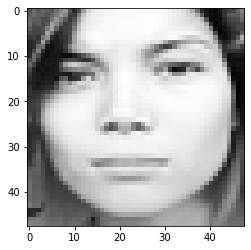

In [85]:
# Taking a glipse over how do the images look like

from matplotlib import pyplot as plt

img0 = full_data['pixels'].iloc[10].reshape(48,48)
plt.imshow(img0, cmap = 'gray');

In [86]:
### The ovarall idea of the pipeline

# We need to form some dataset with balanced classes, e.g. 100 random images from each category
# Then we build and approximation matrix F_norm, which can be induced by subtracting the mean and SVD truncation of the residual
# We project the test images on our singular vector space and therefore we find the closest from the prospect of the cosine similarity image to the test one
# We predict the label of the test image to be the same, as the label og the closest train one

# We stabilize the result by feeding e.g. 11 different subdatasets (one may call them batches) to our model and decide the total prediction by common majority vote


### NB f1_score would be used as the measure of quality in the end

In [87]:
# we try to work on the non-preprocessed, raw dataset for the moment

# we create subdatasets to work with eigenfaces

subdata_0 = create_subset_labeled_with(0,full_data)
subdata_1 = create_subset_labeled_with(1,full_data)
subdata_2 = create_subset_labeled_with(2,full_data)
subdata_3 = create_subset_labeled_with(3,full_data)
subdata_4 = create_subset_labeled_with(4,full_data)
subdata_5 = create_subset_labeled_with(5,full_data)
subdata_6 = create_subset_labeled_with(6,full_data)

In [88]:
list_of_datasets = [subdata_0,
                    subdata_1,
                    subdata_2,
                    subdata_3,
                    subdata_4,
                    subdata_5,
                    subdata_6]

In [89]:
# preparing the test data for quality check in the end

TEST_BATCH_SIZE = len(test_set)
testing_batch = construct_a_batch([test_set],TEST_BATCH_SIZE)
F_test = create_F_matrix_from_subdataset(testing_batch)


100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:04<00:00, 126.47it/s]


In [200]:
F_test_norm = subtract_column_mean(F_test)

In [90]:
################################
#HERE STARTS THE RUNNING OF A voting across sevaral models
################################

In [192]:
PREDICTIONS = []

In [201]:
for iters in range(101):

    # we construct a class - balanced subdataset

    TRAIN_BATCH_SIZE = 10
    batch = construct_a_batch(list_of_datasets,TRAIN_BATCH_SIZE)
    # sizes must be (7*second_arg,2)

    # we construct a matrix by columns (vectorized images of the test dataset)
    F0 = create_F_matrix_from_subdataset(batch)

    # we subtract the mean column to normalize it

    F0_norm = subtract_column_mean(F0)

    # we select the approximation strength (rank of truncation), which, obviously, should be less then min(F0.shape[0],F0.shape[1])

    R = 10


    # we build an R-rank approximation of the centralized F-matrix

    F0_norm_approx = approximate_with_rank(F0_norm, r = R)

    # we glimpse at the uniformness of approximation mistakes

    #plt.spy(F0_norm - F0_norm_approx,10); 

    # we decompose it again, but now keeping the factors

    U0,S0,Vh0 = approximate_with_rank(F0_norm, 
                                      r = R,
                                      return_decomposition=True)

    # we have a glimpse at the first columns of the U matrix, which form a basis in the space of faces (first several)
    # we wont need it in the last pipeline
    #plot_eigf(U0,3)

    # to make a projection of the correspondingly dimensioned vector on the subspace of eigenvectors, we need,
    # taking into account the properties of U matrix (unitary), to Compute U^t@vec = coefficients in the basis

    # jyst a debugging cell to check whether the model works on the only image

    test_img_vec = F_test_norm




    # now we need to project our test images on the subspace induced by singular vectors

    # we construct a projection matrix (U is unitary)

    # the shape would be R by len(vec(img)) = 2304

    projection_matrix = U0.T



    # performing the projection

    f2 = projection_matrix@test_img_vec

    # in general in is R by the TEST_BATCH_SIZE

    

    # the correspondency matrix, with which to compare (we search for the image with quite the same coefficients in linear combination)

    W = np.diag(S0)@Vh0


    dist = (cosine_similarity(f2.T, W.T).argmax(axis=1))



    prediction = batch['emotion'].iloc[dist]
    prediction = np.array(prediction)
    #print(prediction[:5])
    #print(prediction.shape)

    y_true = np.array(testing_batch['emotion'])

    f1_score(y_true,
             prediction,
             average='micro')
    
    PREDICTIONS.append(prediction)

100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 3737.56it/s]


In [208]:
p = np.concatenate(PREDICTIONS[-101:])
p = p.reshape(-1,test_set.shape[0])

In [209]:
p.shape

(101, 625)

In [211]:
all_pred = np.int64(np.median(p,axis = 0))

In [223]:
f1_score(all_pred,y_true,average='weighted')

0.29822841056586824

In [213]:
import sklearn
sklearn.metrics.confusion_matrix(all_pred,y_true,[0,1,2,3,4,5,6])

C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  1,  2,  0,  2,  1],
       [29,  5, 24, 21, 15, 12, 24],
       [53,  5, 61, 94, 52, 41, 70],
       [ 9,  0,  7, 22, 16, 18, 29],
       [ 0,  0,  1,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  0,  0,  0]], dtype=int64)